# Notebook for KFOLD training based on Walkie's code

In [1]:
import numpy as np
import os
import time
import argparse
import random
import sys
import tensorflow as tf
print(f"TensorFlow {tf.__version__}")



'''
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print(f"Number of available GPUs : {len(gpus)}")
    tf.config.set_visible_devices(gpus[0],"GPU")
    tf.config.experimental.set_memory_growth(gpus[0],True)
else:
    print("No GPU available, using CPU !!!")    
'''    
# To disable GPU use
tf.config.set_visible_devices([], 'GPU')

    
# with tf.device('CPU: 0'):
# with tf.device('GPU: 0'): 

#tf.device('CPU: 0')


# Define model hyperparameters 
seed = 175   # random seed
kfolds = 5   # number o folds
nfeat=3      # number of constituents features
nepochs=200   # number of epochs
#lr=0.0005    # learning rate
patience=20  # patience 
MTR='val_accuracy' # Metric
#PRUNE_RATE = 0.01 # Pruning percentage
PRUNE_RATE = 0.5 # Pruning percentage

# Set numer of constituents and bitwidth
nconstit=32   # number of constituents
nbits=8      # QKeras bitwidth

# Define architecture name
arch = "QMLP"
#arch = "QMLPBN"
#arch = "QGCN"

TensorFlow 2.8.0


## Define the model

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Concatenate,
    Flatten,
    BatchNormalization,
    Activation,
    GlobalAveragePooling1D,
    AveragePooling1D,
    Reshape,
    UpSampling1D,
    Add,
)
from tensorflow.keras.optimizers import Adam
from qkeras import QActivation, QDense, QConv1D, QConv2D, quantized_bits
from qkeras.autoqkeras.utils import print_qmodel_summary

from sklearn.metrics import accuracy_score
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from tensorflow.keras import utils, regularizers

#############################################################################


# Quantized bits

#qbits = quantized_bits(nbits,integ,alpha=1.0)
#qact = 'quantized_relu('+str(nbits)+',0)'

# Set QKeras quantizer and activation 
if nbits == 1:
    qbits = 'binary(alpha=1)'
elif nbits == 2:
    qbits = 'ternary(alpha=1)'
else:
    qbits = 'quantized_bits({},0,alpha=1)'.format(nbits)

qact = 'quantized_relu({},0)'.format(nbits)

# Set QKeras linear activation quantization for CONV1D layers to avoid AveragePooling overflow
conv_qbits = 'quantized_bits(15,6)'

#############################################################################

# Load the model definition
if (arch=="QMLP"):
    execfile('mlp.py',globals(),locals())
elif (arch=="QMLPBN"):
    execfile('mlp_bottleneck.py',globals(),locals())
elif (arch=="QGCN"):
    execfile('gcn.py',globals(),locals())
else:
    print("UNKNOWN ARCH !!! ",arch)
    stop
      
#############################################################################


# Print
print("Trainign with max # of contituents = ", nconstit)
print("Number of node features = ", nfeat)
print("Quantization with nbits=",nbits)



# create the model
model = Model(inputs=inp, outputs=out)

# Define the optimizer ( minimization algorithm )
optim = Adam(learning_rate=lr)

# compile the model
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy','categorical_accuracy'])

# Print model summary
model.summary()

# Save model random weights before training to re-initialize weights in each folding
model.save_weights('model.h5')

NINPUT =  96
NOUTPUT =  5
Trainign with max # of contituents =  32
Number of node features =  3
Quantization with nbits= 8
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inp (InputLayer)            [(None, 96)]              0         
                                                                 
 dense_1 (QDense)            (None, 128)               12416     
                                                                 
 activ_1 (QActivation)       (None, 128)               0         
                                                                 
 dense_2 (QDense)            (None, 59)                7611      
                                                                 
 activ_2 (QActivation)       (None, 59)                0         
                                                                 
 dense_3 (QDense)            (None, 76)                4560      
    

## Define Prunnning Function

In [3]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
    
#NSTEPS = int (( int(len(X_train_val) * 0.3))/batch)
#NSTEPS =   int(len(X_train))  // batch
NSTEPS =   480840  // batch

    
def pruneFunction(layer):
    pruning_params = {'pruning_schedule': sparsity.PolynomialDecay( initial_sparsity=0.0, final_sparsity=PRUNE_RATE, begin_step=NSTEPS * 2, end_step=NSTEPS * 10, frequency=NSTEPS ) }
            #pruning_params_mlp_e = {
            #    'pruning_schedule': sparsity.PolynomialDecay(
            #        initial_sparsity=0.0, final_sparsity=0.5, begin_step=NSTEPS * 2, end_step=NSTEPS * 10, frequency=NSTEPS
            #    )
            #}
            
    if isinstance(layer, tf.keras.layers.Conv1D): 
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)

            #if isinstance(layer, tf.keras.layers.Conv1D) and layer.name != 'conv1D_e3':   
            #    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
            #if isinstance(layer, tf.keras.layers.Conv1D) and layer.name == 'conv1D_e3':
            #    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params_mlp_e)

    if isinstance(layer, tf.keras.layers.Dense) and layer.name != 'dense_out': # exclude output_dense
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)

    return layer
    
 

train kfold num: 0

----------------
Data loading complete:
File name: None
Training data size: 480,840
Test data size: 120,210
Number of constituents: 32
Number of features: 3
----------------

(480840, 32, 3)
(480840, 96) (120210, 96) (480840, 5) (120210, 5)
number of G jets for training/validation: 96168/24042
number of Q jets for training/validation: 96168/24042
number of W jets for training/validation: 96168/24042
number of Z jets for training/validation: 96168/24042
number of T jets for training/validation: 96168/24042
number of G jets for testing: 24042
number of Q jets for testing: 24042
number of W jets for testing: 24042
number of Z jets for testing: 24042
number of T jets for testing: 24042
output dir:  model_QMLP_nconst32_nbits8_Seed175_Kfold_20231112-220509
Epoch 1/200


2023-11-12 22:05:09.718731: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


7498/7514 [============================>.] - ETA: 0s - loss: 1.4830 - accuracy: 0.4533 - categorical_accuracy: 0.4533
Epoch 1: val_accuracy improved from -inf to 0.50324, saving model to model_QMLP_nconst32_nbits8_Seed175_Kfold_20231112-220509/model_QMLP_nconst_32_nbits_8_kfold_0.h5
7514/7514 [==============================] - 7s 904us/step - loss: 1.4827 - accuracy: 0.4534 - categorical_accuracy: 0.4534 - val_loss: 1.3370 - val_accuracy: 0.5032 - val_categorical_accuracy: 0.5032 - lr: 4.3297e-04
Epoch 2/200
7462/7514 [============================>.] - ETA: 0s - loss: 1.2700 - accuracy: 0.5276 - categorical_accuracy: 0.5276
Epoch 2: val_accuracy improved from 0.50324 to 0.54487, saving model to model_QMLP_nconst32_nbits8_Seed175_Kfold_20231112-220509/model_QMLP_nconst_32_nbits_8_kfold_0.h5
7514/7514 [==============================] - 7s 884us/step - loss: 1.2698 - accuracy: 0.5276 - categorical_accuracy: 0.5276 - val_loss: 1.2275 - val_accuracy: 0.5449 - val_categorical_accuracy: 0.544

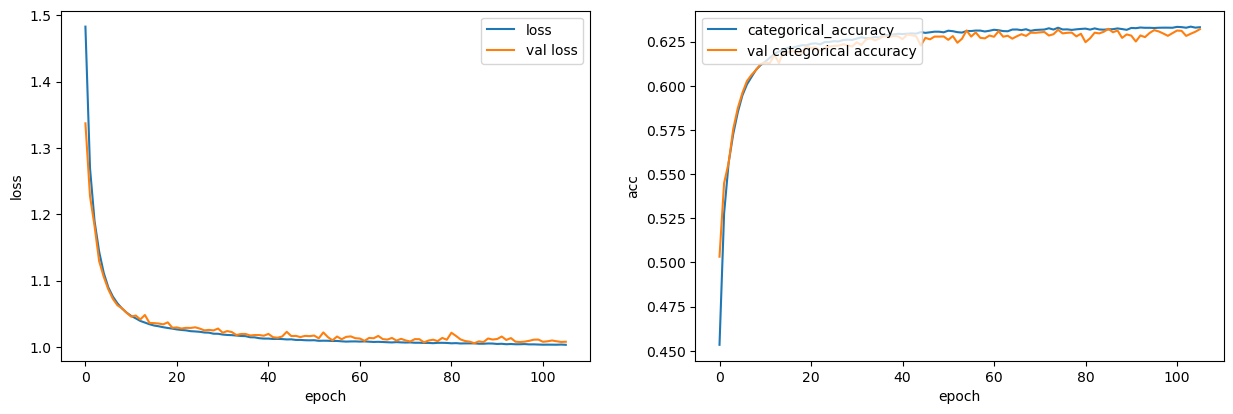

train kfold num: 1

----------------
Data loading complete:
File name: None
Training data size: 480,840
Test data size: 120,210
Number of constituents: 32
Number of features: 3
----------------

(480840, 32, 3)
(480840, 96) (120210, 96) (480840, 5) (120210, 5)
number of G jets for training/validation: 96168/24042
number of Q jets for training/validation: 96168/24042
number of W jets for training/validation: 96168/24042
number of Z jets for training/validation: 96168/24042
number of T jets for training/validation: 96168/24042
number of G jets for testing: 24042
number of Q jets for testing: 24042
number of W jets for testing: 24042
number of Z jets for testing: 24042
number of T jets for testing: 24042
Epoch 1/200
7460/7514 [============================>.] - ETA: 0s - loss: 1.5198 - accuracy: 0.4403 - categorical_accuracy: 0.4403
Epoch 1: val_accuracy improved from -inf to 0.49136, saving model to model_QMLP_nconst32_nbits8_Seed175_Kfold_20231112-220509/model_QMLP_nconst_32_nbits_8_kfol

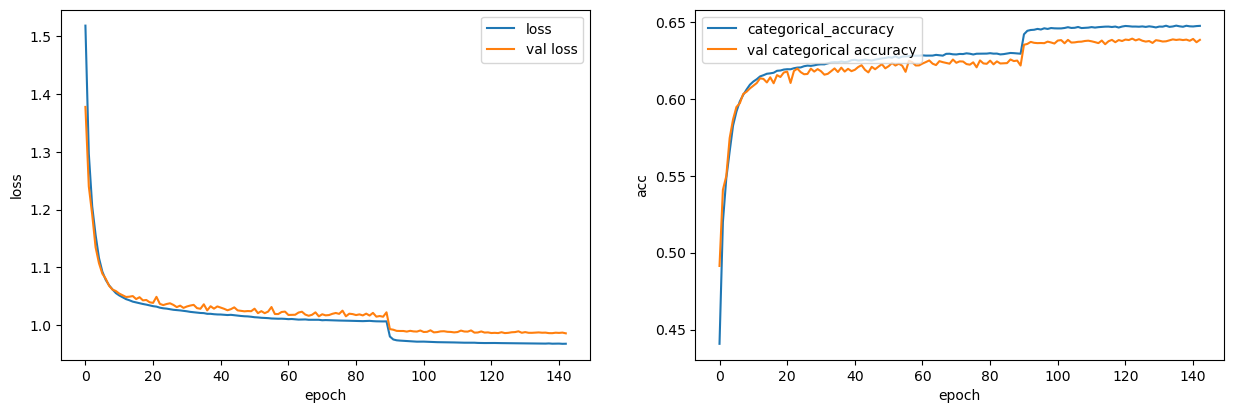

train kfold num: 2

----------------
Data loading complete:
File name: None
Training data size: 480,840
Test data size: 120,210
Number of constituents: 32
Number of features: 3
----------------

(480840, 32, 3)
(480840, 96) (120210, 96) (480840, 5) (120210, 5)
number of G jets for training/validation: 96168/24042
number of Q jets for training/validation: 96168/24042
number of W jets for training/validation: 96168/24042
number of Z jets for training/validation: 96168/24042
number of T jets for training/validation: 96168/24042
number of G jets for testing: 24042
number of Q jets for testing: 24042
number of W jets for testing: 24042
number of Z jets for testing: 24042
number of T jets for testing: 24042
Epoch 1/200
7494/7514 [============================>.] - ETA: 0s - loss: 1.7127 - accuracy: 0.3622 - categorical_accuracy: 0.3622
Epoch 1: val_accuracy improved from -inf to 0.41704, saving model to model_QMLP_nconst32_nbits8_Seed175_Kfold_20231112-220509/model_QMLP_nconst_32_nbits_8_kfol

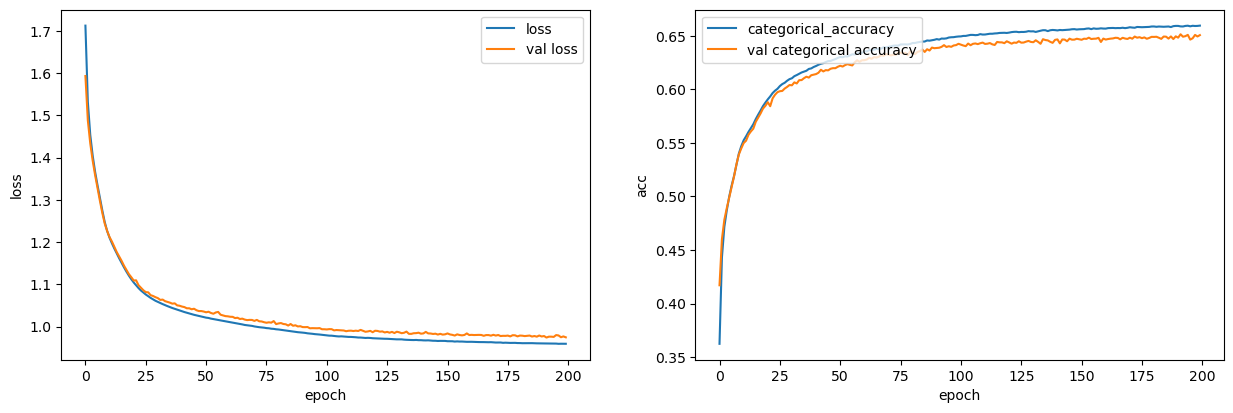

train kfold num: 3

----------------
Data loading complete:
File name: None
Training data size: 480,840
Test data size: 120,210
Number of constituents: 32
Number of features: 3
----------------

(480840, 32, 3)
(480840, 96) (120210, 96) (480840, 5) (120210, 5)
number of G jets for training/validation: 96168/24042
number of Q jets for training/validation: 96168/24042
number of W jets for training/validation: 96168/24042
number of Z jets for training/validation: 96168/24042
number of T jets for training/validation: 96168/24042
number of G jets for testing: 24042
number of Q jets for testing: 24042
number of W jets for testing: 24042
number of Z jets for testing: 24042
number of T jets for testing: 24042
Epoch 1/200
7504/7514 [============================>.] - ETA: 0s - loss: 1.7418 - accuracy: 0.3464 - categorical_accuracy: 0.3464
Epoch 1: val_accuracy improved from -inf to 0.41595, saving model to model_QMLP_nconst32_nbits8_Seed175_Kfold_20231112-220509/model_QMLP_nconst_32_nbits_8_kfol

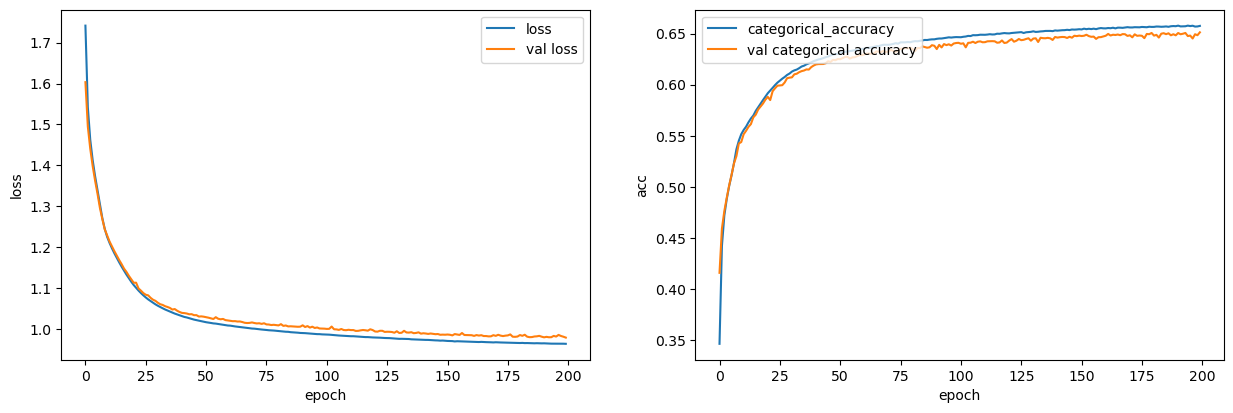

train kfold num: 4

----------------
Data loading complete:
File name: None
Training data size: 480,840
Test data size: 120,210
Number of constituents: 32
Number of features: 3
----------------

(480840, 32, 3)
(480840, 96) (120210, 96) (480840, 5) (120210, 5)
number of G jets for training/validation: 96168/24042
number of Q jets for training/validation: 96168/24042
number of W jets for training/validation: 96168/24042
number of Z jets for training/validation: 96168/24042
number of T jets for training/validation: 96168/24042
number of G jets for testing: 24042
number of Q jets for testing: 24042
number of W jets for testing: 24042
number of Z jets for testing: 24042
number of T jets for testing: 24042
Epoch 1/200
7511/7514 [============================>.] - ETA: 0s - loss: 1.7374 - accuracy: 0.3486 - categorical_accuracy: 0.3486
Epoch 1: val_accuracy improved from -inf to 0.41259, saving model to model_QMLP_nconst32_nbits8_Seed175_Kfold_20231112-220509/model_QMLP_nconst_32_nbits_8_kfol

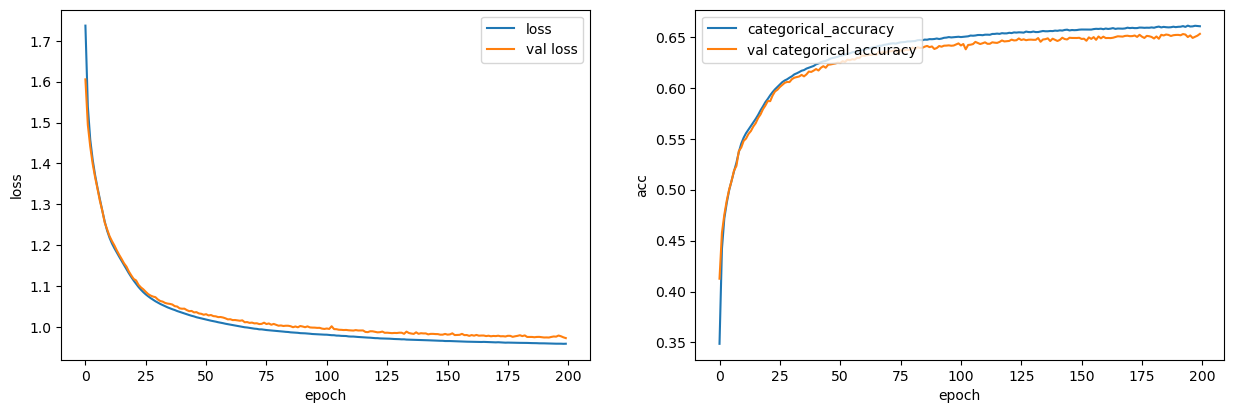

In [4]:
import util.data
import util.plots
import util.util
from util.terminal_colors import tcols
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

nmax = nconstit
accuracy_keras = []



# Loop of training folds
with tf.device('CPU: 0'):   # disable M1 metal GPU 
  for i in range (kfolds):
  
    # Load random weights initialization before any training to reset weights. Otherwise Keras starts from last trained model weights ...
    model.load_weights('model.h5')
    
    print("train kfold num:", i)
    val_kfold = i 

    #test_kfold = args.TK
    train_kfolds = [kfold for kfold in range(kfolds) if kfold != val_kfold]

    
    fpath = f'./data_kfold/jets_{nmax}constituents_ptetaphi_nonorm'
    fnames_train = [f'jet_images_c{nmax}_minpt2.0_ptetaphi_nonorm_{train_kfold}'
                     for train_kfold in train_kfolds]
    fname_val = f'jet_images_c{nmax}_minpt2.0_ptetaphi_nonorm_{val_kfold}'

    data = util.data.Data.load_kfolds(fpath, fnames_train, fname_val)
    print (data.train_data.shape)


    X_train = data.train_data
    X_val = data.test_data
    X_test = data.test_data

    Y_train = data.train_target
    Y_val = data.test_target
    Y_test = data.test_target    
  

    # Nomalization
    interquantile_range_32 = [120, 0.27, 0.27]
    interquantile_range_16 = [166, 0.24, 0.24]
    interquantile_range_8  = [219, 0.20, 0.20]
    
    if nmax == 8:
        X_train = X_train / interquantile_range_8
        X_val   = X_val   / interquantile_range_8
        X_test  = X_test  / interquantile_range_8
    elif nmax == 16:
        X_train = X_train / interquantile_range_16
        X_val   = X_val   / interquantile_range_16
        X_test  = X_test  / interquantile_range_16
    elif nmax == 32:
        X_train = X_train / interquantile_range_32
        X_val   = X_val   / interquantile_range_32
        X_test  = X_test  / interquantile_range_32

    # Flatten data for MLP input
    if (arch!='QGCN'):        
        X_train = X_train.reshape(-1, NINPUT)
        X_val   = X_val.reshape(-1, NINPUT)
        X_test  = X_test.reshape(-1, NINPUT)
    
    
    print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

    print( f"number of G jets for training/validation: {np.sum(np.argmax(Y_train, axis=1) == 0)}/{np.sum(np.argmax(Y_val, axis=1) == 0)}")
    print( f"number of Q jets for training/validation: {np.sum(np.argmax(Y_train, axis=1) == 1)}/{np.sum(np.argmax(Y_val, axis=1) == 1)}")
    print( f"number of W jets for training/validation: {np.sum(np.argmax(Y_train, axis=1) == 2)}/{np.sum(np.argmax(Y_val, axis=1) == 2)}")
    print( f"number of Z jets for training/validation: {np.sum(np.argmax(Y_train, axis=1) == 3)}/{np.sum(np.argmax(Y_val, axis=1) == 3)}")
    print( f"number of T jets for training/validation: {np.sum(np.argmax(Y_train, axis=1) == 4)}/{np.sum(np.argmax(Y_val, axis=1) == 4)}")

    
    print("number of G jets for testing: %i" % np.sum(np.argmax(Y_test, axis=1) == 0))
    print("number of Q jets for testing: %i" % np.sum(np.argmax(Y_test, axis=1) == 1))
    print("number of W jets for testing: %i" % np.sum(np.argmax(Y_test, axis=1) == 2))
    print("number of Z jets for testing: %i" % np.sum(np.argmax(Y_test, axis=1) == 3))
    print("number of T jets for testing: %i" % np.sum(np.argmax(Y_test, axis=1) == 4))
    
#######################################################################################

    mname = "model_{}_nconst_{}_nbits_{}_kfold_{}".format(arch,nmax,nbits,val_kfold)

    if(i==0):
        outputdir = "model_{}_nconst{}_nbits{}_Seed{}_Kfold_{}".format(
            arch,
            nconstit,
            nbits,
            seed,
            time.strftime("%Y%m%d-%H%M%S"),
        )
        print("output dir: ", outputdir)
        os.mkdir(outputdir)

        # early stopping callback
        es = EarlyStopping(monitor=MTR, patience=patience)
        # Learning rate scheduler
        ls = ReduceLROnPlateau(monitor=MTR, factor=0.2, patience=patience)
        #
        pr = pruning_callbacks.UpdatePruningStep() 

        
    
    # Define model checkpoint ( mname changes with folding number !!! ) 
    chkp = ModelCheckpoint(outputdir+"/"+mname+".h5", monitor=MTR, verbose=1, save_best_only=True, save_weights_only=False, mode="auto", save_freq="epoch")

    # Train classifier
    history = model.fit(
                        X_train,
                        Y_train,
                        epochs=nepochs,
                        batch_size=batch,  # small batch
                        verbose=1,
                        callbacks=[es, ls, chkp, pr],
                        #validation_split=0.2,
                        validation_data=(X_val, Y_val),
                        shuffle=True
                        )


    # Plot loss vs epoch
    plt.figure(figsize=(15,10))
    ax = plt.subplot(2, 2, 1)
    ax.plot(history.history['loss'], label='loss')
    ax.plot(history.history['val_loss'], label='val loss')
    ax.legend(loc="upper right")
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

    # Plot training accuracy vs epoch
    ax = plt.subplot(2, 2, 2)
    #ax.plot(history.history['accuracy'], label='accuracy')
    #ax.plot(history.history['val_accuracy'], label='val accuracy')
    ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
    ax.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
    ax.legend(loc="upper left")
    ax.set_xlabel('epoch')
    ax.set_ylabel('acc')

    # Display plots
    fig = plt.gcf()
    plt.show()
#    fig.savefig(fname+'.pdf')


    
    # Retrieve the best model
    model = tf.keras.models.load_model(
        "{}/{}.h5".format(outputdir, mname),
        custom_objects={
            "QDense": QDense,
            "QActivation": QActivation,
            "QConv1D": QConv1D,
            "QConv2D": QConv2D,
            "quantized_bits": quantized_bits,
#            "NodeEdgeProjection": NodeEdgeProjection,
            "PruneLowMagnitude": pruning_wrapper.PruneLowMagnitude,
        },
    )
    
    '''
    # Get predictions for the best model
    y_keras = model.predict(X_test)    
    # Store best model predictions
    accuracy_keras.append(float( accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_keras, axis=1))))
    '''
    
    # Store the accuracy for a given fold
    Y_pred = model.predict(X_test)
    accuracy = tf.keras.metrics.CategoricalAccuracy()
    accuracy.update_state(Y_test, Y_pred)
    accuracy_keras.append( accuracy.result().numpy() )
    


## Saves accuracy and errors for paper plots

In [5]:
#        kfold_metrics = {
#            "fprs": [],
#            "aucs": [],
#            "fats": [],
#            "accs": [],
#            "loss": []
#        }

#plots_dir = outputdir
#
#roc_metrics = util.plots.roc_curves(plots_dir, y_keras, data.test_target)
#util.plots.dnn_output(plots_dir, y_keras)

accuracy_average = np.mean(np.array(accuracy_keras))
accuracy_errs = np.std(np.array(accuracy_keras))


accs = np.zeros(3)
accs[0] = accuracy_average
accs[2] = accuracy_errs

np.savetxt("{}/acc.txt".format(outputdir), accs, fmt="%.6f")
print("Keras:\n", accuracy_keras)

print("output dir: ", outputdir)


Keras:
 [0.63218534, 0.63924795, 0.6514017, 0.65116876, 0.65306544]
output dir:  model_QMLP_nconst32_nbits8_Seed175_Kfold_20231112-220509
